# Synthetic Strong Lens Generator

This notebook grabs pairs of spectra from observed DESI tiles and combines them according to the expression

$$
\mathcal{M}_3 = \alpha\mathcal{M}_1 + (1-\alpha)\mathcal{M}_2,
$$

where $\mathcal{M}_1$ is a model (redrock template) fit to the first observation and $\mathcal{M}_2$ is a model fit to the second spectrum. The value $\alpha$ is a uniformly generated parameter, e.g., $\alpha\sim U(0.1, 0.9)$. Given a model $\mathcal{M}_3$, the code computes a new realization of the flux of the combined spectra $f_3$.

Pairs of spectra are chosen (as of June 2021) from the same tile to ensure equal exposure times. Good redshift fits (`DELTACHI2>25` and `ZWARN==0`) are required. The member of the pair with the lower redshift value is referred to as the "lens," while the higher-redshift spectrum is the "background" object.

All spectra are saved in `desispec.Spectra` format. The following files are kept:
- `tileXXXXX_lens_spectra.fits`: Spectra of the lower-redshift objects in the selected pairs from tile ID XXXXX.
- `tileXXXXX_bkgd_spectra.fits`: Spectra of the higher-redshift objects in the selected pairs from tile ID XXXXX.
- `tileXXXXX_simlens_spectra.fits`: Combined spectra of the pairs from tile XXXXX.

The `Spectra` are stored with two additional tables:
1. `extra`: a table of model fits from redrock, keyed by spectrograph ('b', 'r', 'z').
2. `extra_catalog`: a table of `ZBEST` redshift fit and template fit coefficients from redrock.

### For the Impatient

The majority of this notebook contains functions that handle the spectrum bookkeeping. The code that actually generates the lenses is in the bottom 1/3 of the notebook starting in the section on [Generating Lenses](#generate_lens).

In [1]:
from glob import glob

from astropy.io import fits
from astropy.table import Table, join, vstack, hstack, unique

from desispec.io import read_spectra
from desispec.spectra import stack as specstack
from desispec.spectra import Spectra
from desispec.coaddition import coadd
from desispec.interpolation import resample_flux
from desispec.resolution import Resolution

import redrock.templates

import os

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.rc('font', size=16)
mpl.rc('axes', titlesize='medium')

## Set up Redrock Templates

Instantiate a set of redrock templates for later use in constructing $\mathcal{M}_1$ and $\mathcal{M}_2$.

In [3]:
templates = dict()
for f in redrock.templates.find_templates():
    t = redrock.templates.Template(f)
    templates[(t.template_type, t.sub_type)] = t

DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits


## Bookkeeping Functions

A set of convenience functions to extract redshifts and spectra for the tile from a given spectroscopic reduction.

In [4]:
def get_zbest_data(tilefolder):
    """Given a path to a tile folder, extract all ZBEST and FIBERMAP data from the tile.
    
    Parameters
    ----------
    tilefolder : str
        Path to the spectroscopic reduction corresponding to a particular tile.
    
    Returns
    -------
    zbest : astropy.Table
        Table of best fit redshifts.
    fibermap : astropy.Table
        Fibermap table from this tile.
    """
    # List all zbest files in the tile folder.
    zbfiles = sorted(glob('{}/zbest*fits'.format(tilefolder)))
    zbest, fibermap = None, None
    
    # Spin through all files, corresponding to individual petals.
    for zbfile in zbfiles:
        _zbest = Table.read(zbfile, 'ZBEST')
        # Select galaxies and QSOs with a solid redshift.
        select = (_zbest['SPECTYPE'] != 'STAR') & (_zbest['ZWARN']==0) & (_zbest['DELTACHI2']>=25)
        _zbest = _zbest[select]
        
        _fibermap = Table.read(zbfile, 'FIBERMAP')
        idx = np.in1d(_fibermap['TARGETID'], _zbest['TARGETID'])
        n = len(_zbest)
        _fibermap = _fibermap[idx]#[-n:]
        
        if zbest is None or fibermap is None:
            zbest = _zbest
            fibermap = _fibermap
        else:
            zbest = vstack([zbest, _zbest])
            fibermap = vstack([fibermap, _fibermap])
            
    return zbest, fibermap

In [5]:
def select_pairs(zbest, fibermap, fraction=0.05):
    """Given a zbest and fibermap table, select random pairs of spectra (without replacement).
    
    Parameters
    ----------
    zbest : astropy.Table
        Table of best fit redshifts from a single tile.
    fibermap : astropy.Table
        Fibermap table from this tile.
    fraction : float
        Fraction of targets in the tile to use when generating pairs. Should be in [0,1].
        
    Returns
    -------
    zlentab : astropy.Table
        Table of redshift data for the randomly selected low-redshift "lens."
    zbkgtab : astropy.Table
        Table of redshift data for the randomly selected high-redshift "background" object.
    zjointab : astropy.Table
        A Cartesian join of zlentab and zbkgtab for later use.
    lentargets : astropy.Table
        The TARGETID, TILEID, PETAL_LOC of the "lens" objects.
    bkgtargets : astropy.Table
        The TARGETID, TILEID, PETAL_LOC of the "background" objects.
    """
    # Select pairs of galaxies and QSOs.
    pairs = np.random.choice(zbest['TARGETID'], [int(fraction*len(zbest)), 2], replace=False)

    # Loop through pairs of TARGETIDs.
    zlentab, zbkgtab, zjointab = None, None, None

    for pair in pairs:
        # Check the fibermap table to ensure the exposure times of the lens and background are equal.
        # Unequal total exposure times could occur if a petal or a CANBus was disabled during one exposure. 
        select0 = np.in1d(fibermap['TARGETID'], pair[0])
        select1 = np.in1d(fibermap['TARGETID'], pair[1])
        i, j = np.where(select0)[0], np.where(select1)[0]
        exptime0, exptime1 = [np.sum(fibermap[_]['EXPTIME']) for _ in (i,j)]
        if exptime0 != exptime1:
            continue

        # Sort to make index k the "lens" and index l the "background" galaxy.
        select = np.in1d(zbest['TARGETID'], pair)
        pairdata = zbest[select]
        k, l = np.where(select)[0] if pairdata[0]['Z'] < pairdata[1]['Z'] else np.where(select)[0][::-1]

        # Then join the two ZBEST table entries into one row.
        row = join(zbest[k], zbest[l], join_type='cartesian')

        # Generate a random number giving the relative contribution of objects 1 and 2.
        alpha = np.random.uniform(0.1, 0.9)
        row['ALPHA'] = alpha

        # Accumulate the rows of pairs of "lenses" and "background" galaxies.
        if zjointab is None:
            zjointab = row
            zlentab = zbest[k]
            zbkgtab = zbest[l]
        else:
            zjointab = vstack([zjointab, row])
            zlentab = vstack([zlentab, zbest[k]])
            zbkgtab = vstack([zbkgtab, zbest[l]])
            
    i = np.in1d(fibermap['TARGETID'], zlentab['TARGETID'])
    lentargets = unique(fibermap[i]['TARGETID', 'TILEID', 'PETAL_LOC'])

    i = np.in1d(fibermap['TARGETID'], zbkgtab['TARGETID'])
    bkgtargets = unique(fibermap[i]['TARGETID', 'TILEID', 'PETAL_LOC'])
    
    return zlentab, zbkgtab, zjointab, lentargets, bkgtargets

In [6]:
def get_coadds(ztab, targtab):
    """Given a table of ZBEST data and TARGET info, extract coadds to a Spectra object.
    
    Parameters
    ----------
    ztab : astropy.Table
        Table of ZBEST data of selected spectra.
    targab : astropy.Table
        The TARGETID, TILEID, PETAL_LOC of the selected spectra.
        
    Returns
    -------
    targspec : desispec.Spectra
        Spectra object with a list of spectra, including fibermaps, redshift fits (in extra_catalog), and template fits (in extra).
    """
    tile = targtab['TILEID'][0]
    tilefolder = sorted(glob('{}/{}/{}/*'.format(os.environ['DESI_SPECTRO_REDUX'], redux, tile)))[-1]

    targspec = None

    for petal in np.unique(targtab['PETAL_LOC']):
        coadd_file = glob('{}/coadd-{}*.fits'.format(tilefolder, petal))[0]
        coadds = read_spectra(coadd_file)

        # Extract selected spectra from this petal.
        targetids = targtab[targtab['PETAL_LOC'] == petal]['TARGETID']
        i = np.in1d(coadds.fibermap['TARGETID'], targetids)
        coadds = coadds[i]

        if targspec is None:
            targspec = coadds
        else:
            targspec = specstack([targspec, coadds])

    # Unscramble the indices so the order of the spectra matches our coadd...
    idx = np.nonzero(ztab['TARGETID'][:,None] == targspec.fibermap['TARGETID'])[1]
    targspec = targspec[idx]
    targspec.extra_catalog = ztab

    # Compute and store model fluxes from redrock.
    targspec.extra = {}
    for band in 'brz':
        model = []

        for i in range(targspec.num_spectra()):
            # Get the redrock best fit model for the lens.
            z = targspec.extra_catalog[i]['Z']
            sp, sb = targspec.extra_catalog[i]['SPECTYPE'], targspec.extra_catalog[i]['SUBTYPE']
            ncoeff = templates[(sp, sb)].flux.shape[0]
            coeff = targspec.extra_catalog[i]['COEFF'][0:ncoeff]
            tflux = templates[(sp, sb)].flux.T.dot(coeff)
            twave = templates[(sp, sb)].wave * (1 + z)

            R = Resolution(targspec.resolution_data[band][i])
            txflux = R.dot(resample_flux(targspec.wave[band], twave, tflux))
            model.append(txflux)

        targspec.extra[band] = { 'model' : np.asarray(model) }

    # Turn off scores.
    if not hasattr(targspec, 'scores_comments'):
        targspec.scores_comments = None
    
    return targspec

In [7]:
def generate_lens_spectra(zjointab, lenspec, bkgspec, alpha_min=0.1, alpha_max=0.9):
    """Generate realizations of strong lenses by adding the spectra.
    The result is combo = alpha*lens + (1-alpha)*bkgd
    
    Parameters
    ----------
    zjointab : astropy.Table
        Joined table of redshift info from the lens and background objects.
    lenspec : desispec.Spectra
        Spectra for objects that are the "lenses" in our strong lens systems.
    bkgspec : desispec.Spectra
        Spectra for objects that are "backgrounds" in our strong lens systems.
    alpha_min : float
        Minimum alpha. Should be in [0,1] and < alpha_max.
    alpha_max : float
        Maximum alpha. Should be in [0,1] and > alpha_min.
        
    Returns
    -------
    newspec : Spectra
        A Spectra object with a list of synthetic lensed spectra.
    """
    # Build up a list of arrays and dictionaries needed to instantiate Spectra.
    bands = []
    wave = {} 
    flux = {}
    ivar = {}
    mask = {}
    fibermap = None
    extra = {}
    extra_catalog=None

    # Loop through the observed bands and merge the model fits.
    for band in 'brz':
        f1, w1 = lenspec.flux[band], lenspec.ivar[band]
        m1 = []
        f2, w2 = bkgspec.flux[band], bkgspec.ivar[band]
        m2 = []
        alpha = zjointab['ALPHA'][:,None]
        w3 = w1*w2 / (alpha*w2 + (1-alpha)*w1)

        # Add the models using the alpha parameter to tune the relative contribution of the lens and background object.
        m1 = lenspec.extra[band]['model']
        m2 = bkgspec.extra[band]['model']
        m3 = alpha*m1 + (1-alpha)*m2

        # Compute a "noise" vector using the differences between the observed fluxes and model fits.
        n3 = np.sqrt(alpha*(f1-m1)**2 + (1-alpha)*(f2-m2)**2)

        # Create a realized flux as a Gaussian with expectation given by the model and 
        # width given by the noise vector.
        f3 = np.random.normal(loc=m3, scale=n3)

        # Set up the spectrum wavelength, flux, variance, mask, bands.
        wave[band] = lenspec.wave[band]
        flux[band] = f3
        ivar[band] = w3
        mask[band] = lenspec.mask[band] | bkgspec.mask[band]
        bands.append(band)
        extra[band] = { 'model' : m3 }

    # Set up the fibermap as a join of the lens and background fibermaps.
    for row1, row2 in zip(lenspec.fibermap, bkgspec.fibermap):
        newrow = join(row1, row2, join_type='cartesian')
        if fibermap is None:
            fibermap = newrow
        else:
            fibermap = vstack([fibermap, newrow])

    # Add redshift info from the two individual spectra as an extra catalog.
    extra_catalog = zjointab

    newspec = Spectra(bands, wave, flux, ivar, mask, fibermap=fibermap, extra=extra, extra_catalog=extra_catalog)
    return newspec

### Temporary Spectra I/O Functions

These are needed to write the `EXTRA_CATALOG` data from the `Spectra` to FITS and then read them back. Will make a commit to `desispec` so these can be removed after June 2021.

In [8]:
import re
import time
import warnings

from desiutil.depend import add_dependencies
from desiutil.io import encode_table
from desispec.io import iotime
from desispec.io.util import fitsheader, native_endian, add_columns
from desispec.io.fibermap import fibermap_comments
from desiutil.log import get_logger

def write_spectra_wrap(outfile, spec, units=None):
    """
    Write Spectra object to FITS file. TEMPORARY wrapper of desispec.io.write_spectra.

    This places the metadata into the header of the (empty) primary HDU.
    The first extension contains the fibermap, and then HDUs are created for
    the different data arrays for each band.

    Floating point data is converted to 32 bits before writing.

    Args:
        outfile (str): path to write
        spec (Spectra): the object containing the data
        units (str): optional string to use for the BUNIT key of the flux
            HDUs for each band.

    Returns:
        The absolute path to the file that was written.

    """
    log = get_logger()
    outfile = os.path.abspath(outfile)

    # Create the parent directory, if necessary.
    dir, base = os.path.split(outfile)
    if not os.path.exists(dir):
        os.makedirs(dir)

    # Create HDUs from the data
    all_hdus = fits.HDUList()

    # metadata goes in empty primary HDU
    hdr = fitsheader(spec.meta)
    add_dependencies(hdr)

    all_hdus.append(fits.PrimaryHDU(header=hdr))

    # Next is the fibermap
    fmap = spec.fibermap.copy()
    fmap.meta["EXTNAME"] = "FIBERMAP"
    with warnings.catch_warnings():
        #- nanomaggies aren't an official IAU unit but don't complain
        warnings.filterwarnings('ignore', '.*nanomaggies.*')
        hdu = fits.convenience.table_to_hdu(fmap)
    
    # Add comments for fibermap columns.
    for i, colname in enumerate(fmap.dtype.names):
        if colname in fibermap_comments:
            key = "TTYPE{}".format(i+1)
            name = hdu.header[key]
            assert name == colname
            comment = fibermap_comments[name]
            hdu.header[key] = (name, comment)
        else:
            pass
            #print('Unknown comment for {}'.format(colname))

    all_hdus.append(hdu)
    
    # Now append the data for all bands
    for band in spec.bands:
        hdu = fits.ImageHDU(name="{}_WAVELENGTH".format(band.upper()))
        hdu.header["BUNIT"] = "Angstrom"
        hdu.data = spec.wave[band].astype("f8")
        all_hdus.append(hdu)

        hdu = fits.ImageHDU(name="{}_FLUX".format(band.upper()))
        if units is None:
            hdu.header["BUNIT"] = "10**-17 erg/(s cm2 Angstrom)"
        else:
            hdu.header["BUNIT"] = units
        hdu.data = spec.flux[band].astype("f4")
        all_hdus.append(hdu)

        hdu = fits.ImageHDU(name="{}_IVAR".format(band.upper()))
        if units is None:
            hdu.header["BUNIT"] = '10**+34 (s2 cm4 Angstrom2) / erg2'
        else:
            hdu.header["BUNIT"] = ((u.Unit(units, format='fits'))**-2).to_string('fits')
        hdu.data = spec.ivar[band].astype("f4")
        all_hdus.append(hdu)

        if spec.mask is not None:
            # hdu = fits.CompImageHDU(name="{}_MASK".format(band.upper()))
            hdu = fits.ImageHDU(name="{}_MASK".format(band.upper()))
            hdu.data = spec.mask[band].astype(np.uint32)
            all_hdus.append(hdu)

        if spec.resolution_data is not None:
            hdu = fits.ImageHDU(name="{}_RESOLUTION".format(band.upper()))
            hdu.data = spec.resolution_data[band].astype("f4")
            all_hdus.append(hdu)

        if spec.extra is not None:
            for ex in spec.extra[band].items():
                hdu = fits.ImageHDU(name="{}_{}".format(band.upper(), ex[0]))
                hdu.data = ex[1].astype("f4")
                all_hdus.append(hdu)

    if spec.scores is not None :
        scores_tbl = encode_table(spec.scores)  #- unicode -> bytes
        scores_tbl.meta['EXTNAME'] = 'SCORES'
        all_hdus.append( fits.convenience.table_to_hdu(scores_tbl) )
        if spec.scores_comments is not None : # add comments in header
            hdu=all_hdus['SCORES']
            for i in range(1,999):
                key = 'TTYPE'+str(i)
                if key in hdu.header:
                    value = hdu.header[key]
                    if value in spec.scores_comments.keys() :
                        hdu.header[key] = (value, spec.scores_comments[value])

    if spec.extra_catalog is not None:
        extra_catalog = encode_table(spec.extra_catalog)
        extra_catalog.meta['EXTNAME'] = 'EXTRA_CATALOG'
        all_hdus.append(fits.convenience.table_to_hdu(extra_catalog))
    
    t0 = time.time()
    all_hdus.writeto("{}.tmp".format(outfile), overwrite=True, checksum=True)
    os.rename("{}.tmp".format(outfile), outfile)
    duration = time.time() - t0
    log.info(iotime.format('write', outfile, duration))

    return outfile

def read_spectra_wrap(infile, single=False):
    """
    Read Spectra object from FITS file.

    This reads data written by the write_spectra function.  A new Spectra
    object is instantiated and returned.

    Args:
        infile (str): path to read
        single (bool): if True, keep spectra as single precision in memory.

    Returns (Spectra):
        The object containing the data read from disk.

    """
    log = get_logger()
    ftype = np.float64
    if single:
        ftype = np.float32

    infile = os.path.abspath(infile)
    if not os.path.isfile(infile):
        raise IOError("{} is not a file".format(infile))

    t0 = time.time()
    hdus = fits.open(infile, mode="readonly")
    nhdu = len(hdus)

    # load the metadata.

    meta = dict(hdus[0].header)

    # initialize data objects

    bands = []
    fmap = None
    wave = None
    flux = None
    ivar = None
    mask = None
    res = None
    extra = None
    extra_catalog = None
    scores = None

    # For efficiency, go through the HDUs in disk-order.  Use the
    # extension name to determine where to put the data.  We don't
    # explicitly copy the data, since that will be done when constructing
    # the Spectra object.

    for h in range(1, nhdu):
        name = hdus[h].header["EXTNAME"]
        if name == "FIBERMAP":
            fmap = encode_table(Table(hdus[h].data, copy=True).as_array())
        elif name == "SCORES":
            scores = encode_table(Table(hdus[h].data, copy=True).as_array())
        elif name == 'EXTRA_CATALOG':
            extra_catalog = encode_table(Table(hdus[h].data, copy=True).as_array())
        else:
            # Find the band based on the name
            mat = re.match(r"(.*)_(.*)", name)
            if mat is None:
                raise RuntimeError("FITS extension name {} does not contain the band".format(name))
            band = mat.group(1).lower()
            type = mat.group(2)
            if band not in bands:
                bands.append(band)
            if type == "WAVELENGTH":
                if wave is None:
                    wave = {}
                wave[band] = native_endian(hdus[h].data.astype(ftype))
            elif type == "FLUX":
                if flux is None:
                    flux = {}
                flux[band] = native_endian(hdus[h].data.astype(ftype))
            elif type == "IVAR":
                if ivar is None:
                    ivar = {}
                ivar[band] = native_endian(hdus[h].data.astype(ftype))
            elif type == "MASK":
                if mask is None:
                    mask = {}
                mask[band] = native_endian(hdus[h].data.astype(np.uint32))
            elif type == "RESOLUTION":
                if res is None:
                    res = {}
                res[band] = native_endian(hdus[h].data.astype(ftype))
            else:
                # this must be an "extra" HDU
                if extra is None:
                    extra = {}
                if band not in extra:
                    extra[band] = {}
                extra[band][type] = native_endian(hdus[h].data.astype(ftype))

    hdus.close()
    duration = time.time() - t0
    log.info(iotime.format('read', infile, duration))

    # Construct the Spectra object from the data.  If there are any
    # inconsistencies in the sizes of the arrays read from the file,
    # they will be caught by the constructor.

    spec = Spectra(bands, wave, flux, ivar, mask=mask, resolution_data=res,
        fibermap=fmap, meta=meta, extra=extra, extra_catalog=extra_catalog, single=single, scores=scores)

    return spec

## Generate Lensed Spectra
<a id='generate_lens'></a>

Build a list of SV tiles and generate synthetic strong lenses by pairing spectra.

In [9]:
redux = 'daily/tiles/cumulative'

tiles = sorted(glob('{}/{}/*'.format(os.environ['DESI_SPECTRO_REDUX'], redux)))

sv1tiles = []
sv3tiles = []
for tile in tiles:
    tileid = int(os.path.basename(tile))
    d = sorted(glob('{}/*'.format(tile)))
    if tileid < 20000:
        sv3tiles.append(d[-1])
    if tileid > 80000:
        sv1tiles.append(d[-1]) 

In [10]:
for i, sv3tile in enumerate(sv3tiles):
    # Extract ZBEST and FIBERMAP from all petals in this tile.
    zbest, fibermap = get_zbest_data(sv3tile)
    tileid = fibermap['TILEID'][0]
    print('\nGenerating strong lenses using TILE {}'.format(tileid), flush=True)
    
    # Extract redshift and target ID for randomly selected pairs of objects.
    # The "lens" data will be matched to the "bkg" data and will always have a lower redshift.
    zlentab, zbkgtab, zjointab, lentargets, bkgtargets = select_pairs(zbest, fibermap)
    
    # Extract spectra + redrock fits to Spectra for the "lens" and "background" objects.
    lenspec = get_coadds(zlentab, lentargets)
    bkgspec = get_coadds(zbkgtab, bkgtargets)
    
    # Produce synthetic strong lenses.
    newspec = generate_lens_spectra(zjointab, lenspec, bkgspec)

    # Write outputs to FITS.
    write_spectra_wrap('tile{:06d}_lens_spectra.fits'.format(tileid), lenspec)
    write_spectra_wrap('tile{:06d}_bkgd_spectra.fits'.format(tileid), bkgspec)
    write_spectra_wrap('tile{:06d}_simlens_spectra.fits'.format(tileid), newspec)
    
    if i >= 0:
        break


Generating strong lenses using TILE 1
INFO:spectra.py:253:read_spectra: iotime 0.673 sec to read coadd-0-1-thru20210406.fits at 2021-06-17T06:56:24.852144
INFO:spectra.py:253:read_spectra: iotime 0.573 sec to read coadd-1-1-thru20210406.fits at 2021-06-17T06:56:25.869173
INFO:spectra.py:253:read_spectra: iotime 0.479 sec to read coadd-2-1-thru20210406.fits at 2021-06-17T06:56:26.887746
INFO:spectra.py:253:read_spectra: iotime 0.549 sec to read coadd-3-1-thru20210406.fits at 2021-06-17T06:56:27.907598
INFO:spectra.py:253:read_spectra: iotime 0.475 sec to read coadd-4-1-thru20210406.fits at 2021-06-17T06:56:28.843781
INFO:spectra.py:253:read_spectra: iotime 0.716 sec to read coadd-5-1-thru20210406.fits at 2021-06-17T06:56:30.016701
INFO:spectra.py:253:read_spectra: iotime 0.519 sec to read coadd-6-1-thru20210406.fits at 2021-06-17T06:56:31.090705
INFO:spectra.py:253:read_spectra: iotime 0.515 sec to read coadd-8-1-thru20210406.fits at 2021-06-17T06:56:32.208127
INFO:spectra.py:253:read_

### Check that we can Read in the Spectra

In [11]:
lenspec = read_spectra_wrap('tile000001_lens_spectra.fits')
bkgspec = read_spectra_wrap('tile000001_bkgd_spectra.fits')
simspec = read_spectra_wrap('tile000001_simlens_spectra.fits')

INFO:<ipython-input-8-c7bf45d94595>:234:read_spectra_wrap: iotime 0.220 sec to read tile000001_lens_spectra.fits at 2021-06-17T06:57:02.092086
INFO:<ipython-input-8-c7bf45d94595>:234:read_spectra_wrap: iotime 0.232 sec to read tile000001_bkgd_spectra.fits at 2021-06-17T06:57:02.403237
INFO:<ipython-input-8-c7bf45d94595>:234:read_spectra_wrap: iotime 0.166 sec to read tile000001_simlens_spectra.fits at 2021-06-17T06:57:02.672859


### Make Plots

In [12]:
mpl.rc('figure', max_open_warning = 0)

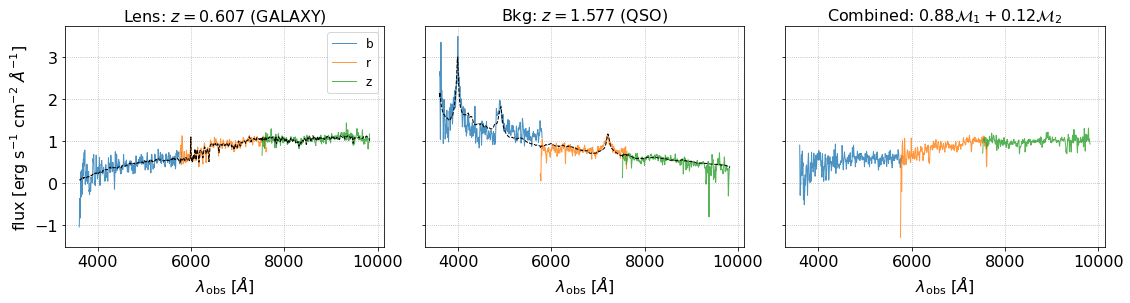

In [14]:
from scipy.ndimage import gaussian_filter1d

for j in range(lenspec.num_spectra()):
    
    fig, axes = plt.subplots(1,3, figsize=(16,4.5), sharex=True, sharey=True, tight_layout=True)

    for b in 'brz':
        ax = axes[0]
        smoothed = gaussian_filter1d(lenspec.flux[b][j], 5)
        ax.plot(lenspec.wave[b], smoothed, lw=1, alpha=0.8, label=b)
        smoothed = gaussian_filter1d(lenspec.extra[b]['MODEL'][j], 5)
        ax.plot(bkgspec.wave[b], smoothed, lw=1, color='k', ls='--')
        ax.set(title='Lens: $z={:.3f}$ ({})'.format(lenspec.extra_catalog[j]['Z'], lenspec.extra_catalog[j]['SPECTYPE']),
               xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]',
               ylabel=r'flux [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]')
        ax.grid(ls=':')

        ax = axes[1]
        smoothed = gaussian_filter1d(bkgspec.flux[b][j], 5)
        ax.plot(bkgspec.wave[b], smoothed, lw=1, alpha=0.8)
        smoothed = gaussian_filter1d(bkgspec.extra[b]['MODEL'][j], 5)
        ax.plot(bkgspec.wave[b], smoothed, lw=1, color='k', ls='--')
        ax.set(title='Bkg: $z={:.3f}$ ({})'.format(bkgspec.extra_catalog[j]['Z'], bkgspec.extra_catalog[j]['SPECTYPE']),
               xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]')
        ax.grid(ls=':')

        ax = axes[2]
        smoothed = gaussian_filter1d(simspec.flux[b][j], 5)
        ax.plot(simspec.wave[b], smoothed, lw=1, alpha=0.8)
        alpha = simspec.extra_catalog['ALPHA'][j]
        ax.set(title=r'Combined: ${:.2f}\mathcal{{M}}_1 + {:.2f}\mathcal{{M}}_2$'.format(alpha, 1-alpha),
               xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]')
        ax.grid(ls=':')
        
    ax = axes[0]
    ax.legend(fontsize=12, ncol=1, loc='best')
        
#     fig.savefig('figures/tile{:06d}_synthlens{:03d}.png'.format(tile, j), dpi=120)
    break